In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from custom_functions import processing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import statistics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# import data
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\data_v10.xlsx'
dataset = pd.read_excel(file_path)
dataset = dataset.drop(['Foldername'], axis=1)
dataset.head()

,Gender,VINCQ32DDN,VINICODEX003,FROPCOM0001,FROPCOM0005,FROPCOM0006_S1_,FROPCOM0006_S2_,FROPCOM0006_S3_,FROPCOM0006_S4_,FROPCOM0006_S5_,...,FROPCOM0004_SQ010_SQ003__1_0_1,FROPCOM0004_SQ010_SQ003__10_0_0,FROPCOM0004_SQ010_SQ003__nan,Frailty_Score,Frailty_State,HADS_D_Score,grip,walk_time_4m,Fried_Score,Fried_State
0,0,76.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,1.0,...,0,0,1,7,0,9,NaN,8.45,2,0
1,0,75.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,4,1,9,21.5,6.11,3,1
2,0,67.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,9,0,10,23.2,20.00,2,0
3,0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,1,7,0,15,17.7,4.87,2,0
4,1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,8,0,10,40.0,3.48,1,0


In [ ]:
# Models
models = {
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=2.7),
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
}

# Hyperparameters
params = {
    'DecisionTree': {
        'max_depth': [5, 7, 10],
        'min_samples_leaf': [2, 5, 10],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy', 'log_loss']
    },


    'XGBoost': {
        'n_estimators': [30, 50,100],
        'max_depth': [ 5, 7, 10],
        'eta': [0.01, 0.1, 0.2],
        'min_child_weight': [1, 2, 4],
        },

    'RandomForest': {
        'n_estimators': [30, 50, 100],
        'max_depth': [5, 8, 10],
        'max_features': ['sqrt', 'log2', None],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
    }
}

Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 36 candid

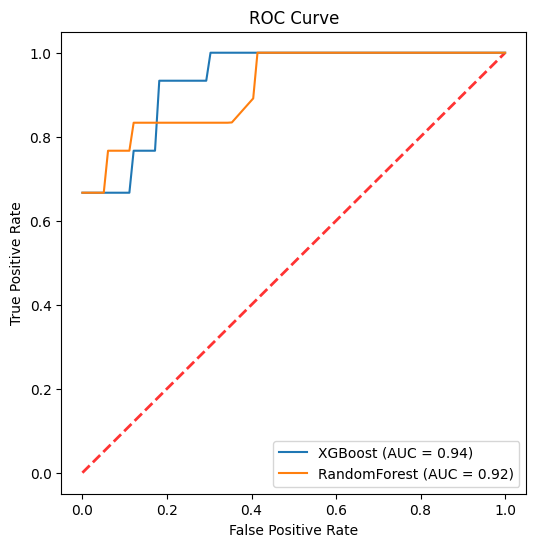

In [ ]:
# Split data
# Use StratifiedKFold to split data into 5 folds and impute missing values

n_splits = 5

model_metrics = {}
tpr_dict = {}  # list to store true positive rates for each fold


# Features
X = dataset.drop(['Fried_State', 'Fried_Score', 'Frailty_State', 'Frailty_Score'], axis=1).values

# Target variable
y = dataset['Fried_State'].values

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each Fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Impute missing values on train set
    X_train_imputed, best_k = processing(X_train, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    X_test_imputed, best_k = processing(X_test, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)


    # Loop through each model and perform grid
    for model_name, model in models.items():
        print(f'Performing Grid Search for {model_name}...')

        # Grid search
        grid_search = GridSearchCV(estimator=model, param_grid=params[model_name], scoring='roc_auc', n_jobs=-1, verbose=1)

        # Initialize the metrics for the current model if not already done
        if model_name not in model_metrics:
            model_metrics[model_name] = {
                'f1_score': [],
                'rec_score': [],
                'roc_auc_score': []
            }

        grid_search.fit(X_train_imputed, y_train)

        # Best parameters
        best_params = grid_search.best_params_
        #print(f'Best Parameters: {best_params}')

        # Best score
        best_score = grid_search.best_score_
        #print(f'Best Score: {best_score}')

        # Best model
        best_model = grid_search.best_estimator_
        #print(f'Best Model: {best_model}')

        # Predictions
        y_pred = best_model.predict(X_test_imputed)

        # Calculate metrics
        y_pred_proba = best_model.predict_proba(X_test_imputed)[:, 1]

        model_metrics[model_name]['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))
        model_metrics[model_name]['rec_score'].append(recall_score(y_test, y_pred, average='weighted'))
        model_metrics[model_name]['roc_auc_score'].append(roc_auc_score(y_test, y_pred_proba))

        # Update TPR list for the model
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if model_name not in tpr_dict:
            tpr_dict[model_name] = []
        tpr_dict[model_name].append(np.interp(np.linspace(0, 1, 100), fpr, tpr))



# Calculate average and std metrics over all folds
for model_name in models.keys():
    for metric in model_metrics[model_name]:
        average_metric = sum(model_metrics[model_name][metric]) / n_splits
        std_metric = statistics.stdev(model_metrics[model_name][metric]) if len(model_metrics[model_name][metric]) > 1 else 0.0
        model_metrics[model_name][metric] = {'average': average_metric, 'std': std_metric}

# Display metrics
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    for metric, values in metrics.items():
        print(f"Average {metric}: {values['average']}, {values['std']}")
        print("=" * 30)

# Calculate average TPR over all folds
average_tpr_dict = {}
for model_name in models.keys():
    sum_tpr = np.sum(np.array(tpr_dict[model_name]), axis=0)
    average_tpr = sum_tpr / n_splits
    average_tpr[-1] = 1.0  # ensure the curve ends at 1
    average_tpr_dict[model_name] = average_tpr

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

for model_name, average_tpr in average_tpr_dict.items():
    average_fpr = np.linspace(0, 1, 100)  # consistent with your np.linspace in the loop
    average_auc = np.trapz(average_tpr, average_fpr)  # Trapezoidal rule for AUC
    plt.plot(average_fpr, average_tpr, label=f"{model_name} (AUC = {average_auc:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

